# Train with Multi-worker

## Step 1: Import libraries

In [1]:
# Library imports
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler, SGD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from torchsummary import summary
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

# Local files imports
from hardware_info import display_cpu_info, display_gpu_info
from plant_model import PlantResNet18, PlantTrainer
from plant_constants import mean, std, num_classes, input_shape, train_dir, valid_dir, test_dir
# from plant_hps import num_epochs, lr_rate, step_size, weight_decay
from plot_evaluation import plot_loss_and_acc, plot_time_and_memory_usage, plot_confusion_matrix

## Step 2: Check hardware information

#### Check CPUs
> Please refer hardware-info.py for details.

In [4]:
display_cpu_info()

CPU:
  CPU: Intel(R) Xeon(R) Gold 6132 CPU @ 2.60GHz
  Architecture: X86_64


#### Check GPU

In [2]:
display_gpu_info()

GPU:
  GPU count: 1
  Name: Tesla V100-SXM2-32GB, Memory Total: 32.00 GB, Memory Free: 28.70 GB


In [3]:
print("CUDA available" if torch.cuda.is_available() else "CUDA unavailable")
if torch.cuda.is_available():
    !nvidia-smi

CUDA available
Sat Dec  2 05:07:51 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           Off | 00000000:AF:00.0 Off |                    0 |
| N/A   56C    P0              82W / 300W |   3109MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------

In [10]:
device = torch.device('cuda')

### Step 3: Data loading

In [15]:
torch.manual_seed(0)

In [5]:
# Define data transforms for training, validation, and testing
def data_loaders(num_workers: int, batch_size=64):
    transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Create datasets using ImageFolder
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False, num_workers=num_workers)
    
    return train_loader, valid_loader

In [7]:
# Load data
num_workers0 = 0

train_loader0, valid_loader0 = data_loaders(num_workers0)
print(len(train_loader0.dataset), len(valid_loader0.dataset))

61494 17572


## Step 4: Define Model
> Please refer the file "plant_model.py" for details. This file defines model class and trainer class: PlantResNet18 and PlantTrainer.

In [8]:
# Create resnet model
model0 = PlantResNet18(num_classes)

# display model summary
print(summary(model0.cuda(), input_shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

#### Move model to GPU

In [9]:
model0.to(device);           # use ; to disable printing

NameError: name 'device' is not defined

## Step 7: Model Training

In [11]:
# Hyperparameters: please refer the plant_hps.py file

# Number of epoch
num_epochs = 5

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = SGD(model0.fc.parameters(), lr=lr_rate, momentum=0.9, weight_decay=weight_decay)

# Learning rate scheduler
scheduler =  lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

In [12]:
trainer0 = PlantTrainer("workers_0__trainer", device, model0, train_loader0, valid_loader0, criterion, optimizer, scheduler, num_epochs)

In [13]:
trainer0.train_model()

Epoch [1/5]-----------------------------------------------------------------------------
| Train Loss: 1.5871 | Train Acc: 0.5680 | Val Loss: 0.5489, Val Acc: 0.8617
| Elapsed Time: 725.7171 s | Max GPU Memory Alloc: 619.1733 MB
Epoch [2/5]-----------------------------------------------------------------------------
| Train Loss: 1.3164 | Train Acc: 0.6243 | Val Loss: 0.4677, Val Acc: 0.8726
| Elapsed Time: 725.2976 s | Max GPU Memory Alloc: 619.1743 MB
Epoch [3/5]-----------------------------------------------------------------------------
| Train Loss: 1.2649 | Train Acc: 0.6333 | Val Loss: 0.4257, Val Acc: 0.8804
| Elapsed Time: 716.6656 s | Max GPU Memory Alloc: 619.1753 MB
Epoch [4/5]-----------------------------------------------------------------------------
| Train Loss: 1.1924 | Train Acc: 0.6494 | Val Loss: 0.3777, Val Acc: 0.9000
| Elapsed Time: 717.7337 s | Max GPU Memory Alloc: 619.1763 MB
Epoch [5/5]-------------------------------------------------------------------------

#### Print and save trainer info

In [14]:
trainer0.display_info()
with open('res/workers_0__trainer.pkl', 'wb') as file:
    pickle.dump(trainer0, file)


total_time: 3600.558070421219
best_valid_acc: 0.9000113817436832
train_loss: [1.587100446551828, 1.3164347432572912, 1.2648846200296664, 1.1924092588872255, 1.1804561381511085]
train_acc: [tensor(0.5680, device='cuda:0', dtype=torch.float64), tensor(0.6243, device='cuda:0', dtype=torch.float64), tensor(0.6333, device='cuda:0', dtype=torch.float64), tensor(0.6494, device='cuda:0', dtype=torch.float64), tensor(0.6521, device='cuda:0', dtype=torch.float64)]
valid_loss: [0.5489361854598703, 0.46771874597125246, 0.4257302262396088, 0.377663690748612, 0.37773357283246833]
valid_acc: [tensor(0.8617, device='cuda:0', dtype=torch.float64), tensor(0.8726, device='cuda:0', dtype=torch.float64), tensor(0.8804, device='cuda:0', dtype=torch.float64), tensor(0.9000, device='cuda:0', dtype=torch.float64), tensor(0.8975, device='cuda:0', dtype=torch.float64)]
epo_elapsed_time: [725.7170536518097, 725.2975654602051, 716.6655557155609, 717.7336542606354, 714.691000699997]
max_alloc: [619.17333984375, 61

## Step 7: Model Evaluation
> Please refer plot_evalution.py for details. This file defines plotting functions.

In [15]:
epoch_list = [i + 1 for i in range(num_epochs)]

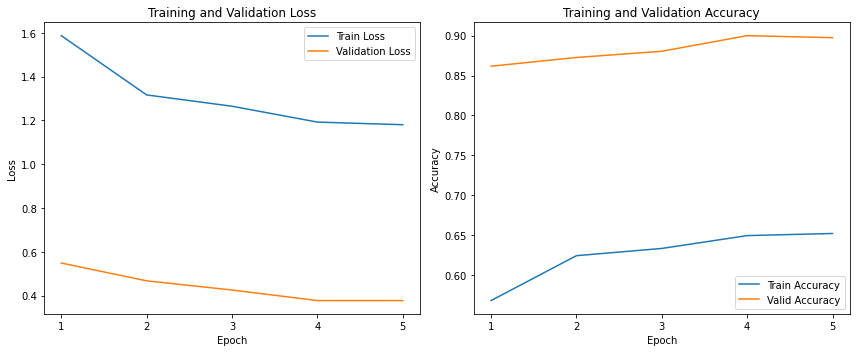

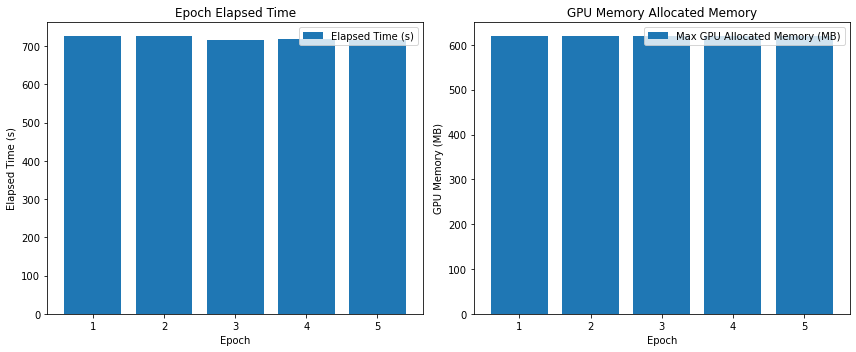

In [16]:
plot_loss_and_acc("workers", num_workers0, epoch_list, trainer0.history)
plot_time_and_memory_usage("workers", num_workers0, epoch_list, trainer0.history)

## Step 7: Multiprocess Comparison
#### When 2 Processes

In [17]:
num_workers2 = 2

train_loader2, valid_loader2 = data_loaders(num_workers2)

model2 = PlantResNet18(num_classes)
model2.to(device)
optimizer = SGD(model2.fc.parameters(), lr=lr_rate, momentum=0.9, weight_decay=weight_decay)

trainer2 = PlantTrainer("workers_2__trainer", device, model2, train_loader2, valid_loader2, criterion, optimizer, scheduler, num_epochs)
trainer2.train_model()

Epoch [1/5]-----------------------------------------------------------------------------
| Train Loss: 1.5906 | Train Acc: 0.5685 | Val Loss: 0.5963, Val Acc: 0.8425
| Elapsed Time: 377.6639 s | Max GPU Memory Alloc: 663.5889 MB
Epoch [2/5]-----------------------------------------------------------------------------
| Train Loss: 1.3077 | Train Acc: 0.6265 | Val Loss: 0.4805, Val Acc: 0.8672
| Elapsed Time: 381.0411 s | Max GPU Memory Alloc: 663.5898 MB
Epoch [3/5]-----------------------------------------------------------------------------
| Train Loss: 1.2684 | Train Acc: 0.6333 | Val Loss: 0.4173, Val Acc: 0.8857
| Elapsed Time: 379.4913 s | Max GPU Memory Alloc: 663.5908 MB
Epoch [4/5]-----------------------------------------------------------------------------
| Train Loss: 1.2479 | Train Acc: 0.6360 | Val Loss: 0.4181, Val Acc: 0.8782
| Elapsed Time: 379.1353 s | Max GPU Memory Alloc: 663.5918 MB
Epoch [5/5]-------------------------------------------------------------------------

In [18]:
trainer2.display_info()
with open('res/workers_2__trainer.pkl', 'wb') as file:
    pickle.dump(trainer2, file)


total_time: 1898.552234172821
best_valid_acc: 0.8856703847029366
train_loss: [1.590565872664614, 1.3076885800425684, 1.2684437688177774, 1.2478698466189893, 1.2361971249203374]
train_acc: [tensor(0.5685, device='cuda:0', dtype=torch.float64), tensor(0.6265, device='cuda:0', dtype=torch.float64), tensor(0.6333, device='cuda:0', dtype=torch.float64), tensor(0.6360, device='cuda:0', dtype=torch.float64), tensor(0.6394, device='cuda:0', dtype=torch.float64)]
valid_loss: [0.5963033603802375, 0.4804650895855515, 0.4172720906405033, 0.41813278189422926, 0.4206241884360193]
valid_acc: [tensor(0.8425, device='cuda:0', dtype=torch.float64), tensor(0.8672, device='cuda:0', dtype=torch.float64), tensor(0.8857, device='cuda:0', dtype=torch.float64), tensor(0.8782, device='cuda:0', dtype=torch.float64), tensor(0.8733, device='cuda:0', dtype=torch.float64)]
epo_elapsed_time: [377.6639392375946, 381.04113817214966, 379.4912648200989, 379.13528633117676, 380.71885228157043]
max_alloc: [663.5888671875,

### When 4 Processes

In [19]:
num_workers4 = 4

train_loader4, valid_loader4 = data_loaders(num_workers4)

model4 = PlantResNet18(num_classes)
model4.to(device)
optimizer = SGD(model4.fc.parameters(), lr=lr_rate, momentum=0.9, weight_decay=weight_decay)

trainer4 = PlantTrainer("workers_4__trainer", device, model4, train_loader4, valid_loader4, criterion, optimizer, scheduler, num_epochs)
trainer4.train_model()

Epoch [1/5]-----------------------------------------------------------------------------
| Train Loss: 1.5909 | Train Acc: 0.5681 | Val Loss: 0.5516, Val Acc: 0.8618
| Elapsed Time: 225.6696 s | Max GPU Memory Alloc: 707.1294 MB
Epoch [2/5]-----------------------------------------------------------------------------
| Train Loss: 1.3124 | Train Acc: 0.6244 | Val Loss: 0.4720, Val Acc: 0.8704
| Elapsed Time: 225.7485 s | Max GPU Memory Alloc: 707.1304 MB
Epoch [3/5]-----------------------------------------------------------------------------
| Train Loss: 1.2639 | Train Acc: 0.6362 | Val Loss: 0.4324, Val Acc: 0.8784
| Elapsed Time: 227.0754 s | Max GPU Memory Alloc: 707.1313 MB
Epoch [4/5]-----------------------------------------------------------------------------
| Train Loss: 1.2394 | Train Acc: 0.6372 | Val Loss: 0.4055, Val Acc: 0.8853
| Elapsed Time: 226.0532 s | Max GPU Memory Alloc: 707.1323 MB
Epoch [5/5]-------------------------------------------------------------------------

In [20]:
trainer4.display_info()
with open('res/workers_4__trainer.pkl', 'wb') as file:
    pickle.dump(trainer4, file)


total_time: 1130.5422735214233
best_valid_acc: 0.8931254268153882
train_loss: [1.5909454316772182, 1.3124105864417617, 1.2638836726446936, 1.2394314348381679, 1.2410963262415058]
train_acc: [tensor(0.5681, device='cuda:0', dtype=torch.float64), tensor(0.6244, device='cuda:0', dtype=torch.float64), tensor(0.6362, device='cuda:0', dtype=torch.float64), tensor(0.6372, device='cuda:0', dtype=torch.float64), tensor(0.6373, device='cuda:0', dtype=torch.float64)]
valid_loss: [0.5516197277640471, 0.4719902421357337, 0.43243964987573985, 0.4054555030013444, 0.37191500657719523]
valid_acc: [tensor(0.8618, device='cuda:0', dtype=torch.float64), tensor(0.8704, device='cuda:0', dtype=torch.float64), tensor(0.8784, device='cuda:0', dtype=torch.float64), tensor(0.8853, device='cuda:0', dtype=torch.float64), tensor(0.8931, device='cuda:0', dtype=torch.float64)]
epo_elapsed_time: [225.66961026191711, 225.74849367141724, 227.0753834247589, 226.0532431602478, 225.25883078575134]
max_alloc: [707.12939453

#### When 8 Processes

In [14]:
num_workers8 = 8

#####################################
num_epochs=10
lr_rate = 0.04
step_size = 7
weight_decay = 2.23e-5
criterion = nn.CrossEntropyLoss()
scheduler =  lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
######################################
train_loader8, valid_loader8 = data_loaders(num_workers8)

model8 = PlantResNet18(num_classes, False)
model8.to(device)
optimizer = SGD(model8.fc.parameters(), lr=lr_rate, momentum=0.9, weight_decay=weight_decay)

trainer8 = PlantTrainer("workers_8__trainer", device, model8, train_loader8, valid_loader8, criterion, optimizer, scheduler, num_epochs)
trainer8.train_model()

/home/zhou.he1/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/10]------------------------------------------------------------------------
| Train Loss: 3.1977 | Train Acc: 0.2065 | Val Loss: 2.6652, Val Acc: 0.2637
| Elapsed Time: 450.6407 s | Max GPU Memory Alloc: 2542.5391 MB
Epoch [2/10]------------------------------------------------------------------------
| Train Loss: 2.7235 | Train Acc: 0.2980 | Val Loss: 2.7071, Val Acc: 0.3341
| Elapsed Time: 454.0714 s | Max GPU Memory Alloc: 2542.5405 MB
Epoch [3/10]------------------------------------------------------------------------
| Train Loss: 2.5995 | Train Acc: 0.3297 | Val Loss: 2.3715, Val Acc: 0.3547
| Elapsed Time: 471.9351 s | Max GPU Memory Alloc: 2542.5415 MB
Epoch [4/10]------------------------------------------------------------------------
| Train Loss: 2.4916 | Train Acc: 0.3530 | Val Loss: 2.4327, Val Acc: 0.3561
| Elapsed Time: 486.0380 s | Max GPU Memory Alloc: 2542.5425 MB
Epoch [5/10]------------------------------------------------------------------------
| Train Los

In [ ]:
trainer8.display_info()
with open('res/workers_8__trainer.pkl', 'wb') as file:
    pickle.dump(trainer8, file)

In [ ]:
plot_loss_and_acc("workers", num_workers8, epoch_list, trainer8.history)
plot_time_and_memory_usage("workers", num_workers8, epoch_list, trainer8.history)

#### Visualize performance

In [1]:
%run plot_comparison.py

In [ ]:
trainers = [trainer0, trainer2, trainer4, trainer8]
worker_list = [0, 2, 4, 8]

time_list = [t.total_time for t in trainers]
speedup_list = [time_list[0] / t for t in time_list]

max_alloc_list = [sum(t.history["max_alloc"]) / len(t.history["max_alloc"]) for t in trainers]

In [ ]:
plot_time_and_speedup("workers", worker_list, time_list, speedup_list)
plot_gpu_usage("workers", worker_list, max_alloc_list)

## Step 9: Fine tuning

#### Unfreeze layers for fine tuning

In [14]:
model8.unfreeze()

In [15]:
tuning_epochs = 5

print("Belows are fine-tuning epochs...")
trainer8t = PlantTrainer("workers_8__trainer_tuning", device, model8, train_loader8, valid_loader8, criterion, optimizer, scheduler, tuning_epochs)
trainer8t.train_model()

Belows are fine-tuning epochs...
Epoch [1/5]-----------------------------------------------------------------------------
| Train Loss: 1.2126 | Train Acc: 0.6441 | Val Loss: 0.3618, Val Acc: 0.8947
| Elapsed Time: 168.7751 s | Max GPU Memory Alloc: 2005.6118 MB
Epoch [2/5]-----------------------------------------------------------------------------
| Train Loss: 1.2036 | Train Acc: 0.6468 | Val Loss: 0.3474, Val Acc: 0.8979
| Elapsed Time: 169.9358 s | Max GPU Memory Alloc: 2005.6133 MB


KeyboardInterrupt: 

#### Concate trainer history

In [18]:
test_dataset = datasets.ImageFolder(root=test_dir, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=0, shuffle=False)

8814


In [42]:
print(len(test_loader.dataset))
print(test_loader.classes)

8814


AttributeError: 'DataLoader' object has no attribute 'classes'

In [ ]:
def concat_trainer_history(t1, t2):
    trainer_history_concat = {}

    for k, v in t1.history.items():
        if k in ['train_acc', 'valid_acc']:
            # Flatten the nested lists for 'train_acc' and 'valid_acc'
            trainer_history_concat[k] = [i for i in t1.history[k]] + [i for i in t2.history[k]]
        else:
            trainer_history_concat[k] = t1.history[k] + t2.history[k]

    return trainer_history_concat

In [ ]:
trainer_history_concat = concat_trainer_history(trainer8, trainer8t)
all_epochs_list = [(i + 1) for i in range(num_epochs + tuning_epochs)]

In [ ]:
plot_loss_and_acc("workers", num_workers8, all_epochs_list, trainer_history_concat)

#### Check test accuracy

In [64]:
# This function is to check final accuarcy with test dataset
def test_accuracy(loader, device, model):
    all_preds = []
    all_labels = []
    
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # preds = torch.argmax(outputs, dim=1)
            # acc = (preds == labels).float().mean()

            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
        
        report = classification_report(
            all_labels, 
            all_preds, 
            labels=np.unique(all_labels), 
            target_names=loader.dataset.classes
        )
        # print(f"Test Accuracy: {acc.item()}")
        print(f"Classification Report:\n{report}")
        cm = confusion_matrix(all_labels, all_preds)
        plot_confusion_matrix(cm, loader.dataset.classes)

    model.train()
    
        #     outputs = model(inputs)
        #     _, preds = torch.max(outputs, 1)
        #     all_preds.extend(preds.cpu().numpy())
        #     all_labels.extend(labels.cpu().numpy())

        # accuracy = accuracy_score(all_labels, all_preds)
        # report = classification_report(all_labels, all_preds, target_names=loader.dataset.classes)
        
        # print(f"Test Accuracy: {accuracy}")
        # print("Classification Report:\n", report)

        # cm = confusion_matrix(all_labels, all_preds)
        # plot_confusion_matrix(cm, loader.dataset.classes)

Classification Report:
                                                   precision    recall  f1-score   support

                               Apple___Apple_scab       0.82      0.05      0.10       264
                                Apple___Black_rot       1.00      0.09      0.16       249
                         Apple___Cedar_apple_rust       0.48      0.61      0.54       220
                                  Apple___healthy       0.69      0.51      0.59       251
                              Blueberry___healthy       0.85      0.63      0.73       227
         Cherry_(including_sour)___Powdery_mildew       0.99      0.58      0.73       211
                Cherry_(including_sour)___healthy       0.99      0.44      0.61       229
Corn_(maize)___Cercospora_leaf_spotGray_leaf_spot       0.99      0.34      0.51       206
                      Corn_(maize)___Common_rust_       0.80      0.98      0.89       239
              Corn_(maize)___Northern_Leaf_Blight       0.93      

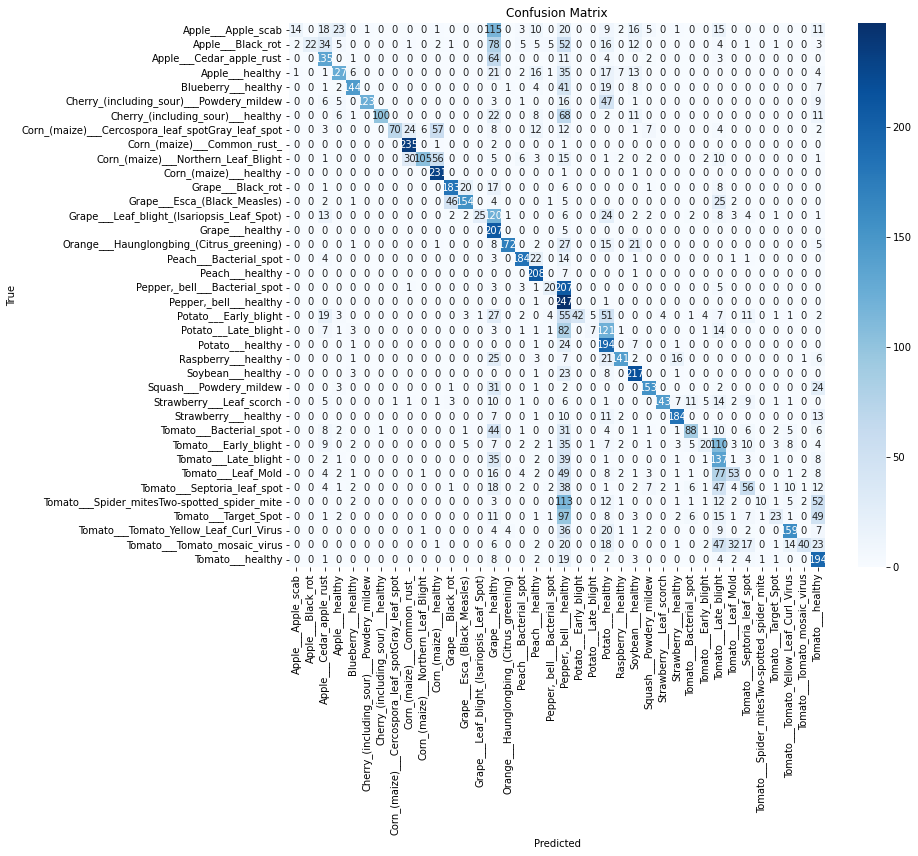

In [65]:
warnings.filterwarnings("ignore")
test_accuracy(test_loader, device, model8)